In [51]:
import pandas as pd
import pathlib
import geopandas as gpd
import matplotlib.pyplot as plt
import pypsa
import numpy as np
import seaborn as sbn

#### Load input data and exploratory analysis

In [52]:
base_path = pathlib.Path("/Users/fabriziofinozzi/Desktop/OpenEnergyTransition/repo/geothermal-modelling")
base_network_pypsa_earth = pypsa.Network(pathlib.Path(base_path, "workflow/pypsa-earth/networks/US_2021/base.nc"))
eia_base_network = gpd.read_file(pathlib.Path(base_path, "analysis/data/US_Electric_Power_Transmission_Lines_5037807202786552385.geojson"))

/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatibl

In [53]:
eia_base_network

,OBJECTID_1,OBJECTID,ID,TYPE,STATUS,NAICS_CODE,NAICS_DESC,SOURCE,SOURCEDATE,VAL_METHOD,VAL_DATE,OWNER,VOLTAGE,VOLT_CLASS,INFERRED,SUB_1,SUB_2,SHAPE__Len,GlobalID,geometry
0,1,1,100511,AC; Overhead,In Service,221121,Electric Bulk Power Transmission and Control,"Imagery, EIA 861, EIA 860","Tue, 08 Nov 2016 00:00:00 GMT",Imagery,"Mon, 27 Mar 2017 00:00:00 GMT",Not Available,115.0,100-161,Yes,Waters River,Tap136228,79.523416,f1500a3a-804a-4da4-b6f6-bd0fbb2cf36d,"LINESTRING (-70.92855 42.54359, -70.92841 42.5..."
1,2,2,140809,AC; Overhead,In Service,221121,Electric Bulk Power Transmission and Control,"Imagery, EIA 860","Wed, 16 Apr 2014 00:00:00 GMT",Imagery,"Wed, 15 Feb 2017 00:00:00 GMT",Kingsport Power Co,161.0,100-161,Yes,Phillips Bend,John Sevier,24018.513114,58c24e54-d758-4071-9ebf-d83beb60c707,"LINESTRING (-82.96123 36.37699, -82.96090 36.3..."
2,3,3,140837,AC; Overhead,In Service,221121,Electric Bulk Power Transmission and Control,"Imagery, https://www9.nationalgridus.com/oasis...","Tue, 16 Jun 2015 00:00:00 GMT",Imagery,"Tue, 05 Mar 2019 00:00:00 GMT",Niagara Mohawk Power Corp.,115.0,100-161,Yes,Tap140359,Tap140373,5972.919614,c40bbff1-b1ed-4905-9ff6-1a80b7b422fc,"LINESTRING (-75.33407 43.08946, -75.33426 43.0..."
3,4,4,140811,AC; Overhead,In Service,221121,Electric Bulk Power Transmission and Control,"Imagery, OpenStreetMap","Fri, 20 Jun 2014 00:00:00 GMT",Imagery,"Mon, 20 Mar 2017 00:00:00 GMT","Entergy New Orleans, Llc",115.0,100-161,Yes,Gentilly Road,Michoud Station,14253.092823,f09483e3-5419-4b94-aac5-a6450f2452c4,"LINESTRING (-89.93728 30.00905, -89.93773 30.0..."
4,5,5,140813,AC; Overhead,In Service,221121,Electric Bulk Power Transmission and Control,"Imagery, EIA 860","Tue, 04 Oct 2016 00:00:00 GMT",Imagery/other,"Wed, 09 May 2018 00:00:00 GMT",Midamerican Energy Co,161.0,100-161,Yes,Unknown137689,Tap137690,8950.844317,36ac4f5e-ad18-47c2-bb7d-8ba64b7fa822,"LINESTRING (-90.56609 41.61256, -90.56468 41.6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94211,94212,94212,313969,AC; Overhead,In Service,221121,Electric Bulk Power Transmission and Control,Imagery,"Tue, 28 Aug 2018 00:00:00 GMT",Imagery/other,"Tue, 24 May 2022 00:00:00 GMT",Sulphur Springs Valley Electric Cooperative,69.0,Under 100,No,Tap302103,Stewart,14234.316259,e2d37fb1-dca0-406f-9033-d692f5f4bc99,"LINESTRING (-109.87545 32.23874, -109.87542 32..."
94212,94213,94213,313970,AC; Overhead,In Service,221121,Electric Bulk Power Transmission and Control,Imagery,"Tue, 16 Oct 2018 00:00:00 GMT",Imagery/other,"Tue, 24 May 2022 00:00:00 GMT",Graham County Electric Cooperative Incorporated,69.0,Under 100,No,Tap300244,Hackberry,25444.741067,3c2f7c5c-728d-4ce3-b663-c2555474b534,"LINESTRING (-109.60459 32.87502, -109.61015 32..."
94213,94214,94214,202495,AC; Overhead,Not Available,221121,Electric Bulk Power Transmission and Control,Imagery,"Wed, 10 Apr 2019 00:00:00 GMT",Imagery,"Wed, 10 Apr 2019 00:00:00 GMT",City Of Gering - (Ne),115.0,100-161,No,Tap204261,Unknown202234,106510.794263,00225744-4cf6-4f33-9d8a-6f458515cad8,"LINESTRING (-104.45345 42.05791, -104.45308 42..."
94214,94215,94215,202496,AC; Overhead,Not Available,221121,Electric Bulk Power Transmission and Control,Imagery,"Wed, 10 Apr 2019 00:00:00 GMT",Imagery,"Wed, 10 Apr 2019 00:00:00 GMT",City Of Gering - (Ne),115.0,100-161,No,Tap161754,Tap204258,49097.232454,17d49594-e00f-4a93-b602-fe5992196552,"LINESTRING (-103.87027 41.81278, -103.87065 41..."


The total number of lines in the EIA dataset is

In [54]:
eia_base_network.shape[0]

94216

At first glance, it is possible to see that some transmission lines correspond to a voltage of -999999.0 kV. In particular the number of lines corresponding to -999999.0 is

In [55]:
eia_base_network.loc[eia_base_network["VOLTAGE"]==-999999.0].shape[0]

14062

which acoounts for almost 15 % of the lines in the EIA dataset

In [56]:
eia_base_network.loc[eia_base_network["VOLTAGE"]==-999999.0].shape[0]/eia_base_network.shape[0]*100

14.9252780844018

For the moment, such lines are filtered out

In [57]:
eia_base_network = eia_base_network.loc[eia_base_network["VOLTAGE"]!=-999999.0]
eia_base_network.shape[0]

80154

Get the voltage bins from the reference data

In [58]:
eia_voltage_bins_flags = eia_base_network["VOLT_CLASS"].unique().tolist()
eia_voltage_bins_flags

['100-161',
 'Under 100',
 '345',
 '220-287',
 '500',
 '735 And Above',
 'Dc',
 'Not Available']

In [59]:
volt_class_min_values = []
volt_class_max_values = []
for bin_name in eia_voltage_bins_flags:
    volt_class_min_values.append(eia_base_network.loc[eia_base_network["VOLT_CLASS"]==bin_name]["VOLTAGE"].min())
    volt_class_max_values.append(eia_base_network.loc[eia_base_network["VOLT_CLASS"]==bin_name]["VOLTAGE"].max())
volt_class_bin_limits = pd.DataFrame(
    {
        "voltage_class": eia_voltage_bins_flags,
        "voltage_class_min": volt_class_min_values,
        "voltage_class_max": volt_class_max_values,
    }
)
volt_class_bin_limits

,voltage_class,voltage_class_min,voltage_class_max
0,100-161,100.0,218.0
1,Under 100,3.0,92.0
2,345,345.0,345.0
3,220-287,220.0,287.0
4,500,500.0,500.0
5,735 And Above,765.0,765.0
6,Dc,200.0,1000.0
7,Not Available,169.0,169.0


The voltage classes in the EIA dataset include also *Dc*. The number of lines corresponding to such voltage class is

In [60]:
eia_base_network.loc[eia_base_network["VOLT_CLASS"]=='Dc'].shape[0]

9

Considering that the PyPSA-Earth base network does not contain any DC line

In [61]:
base_network_pypsa_earth.lines["dc"].unique()

array([False])

the lines corresponding to the *Dc* voltage class are removed from the EIA dataset

In [62]:
eia_base_network = eia_base_network.loc[eia_base_network["VOLT_CLASS"]!='Dc']
eia_base_network.shape[0]

80145

Furthermore, the lines corresponding to the voltage class *Not Available* are removed as well

In [72]:
eia_base_network = eia_base_network.loc[eia_base_network["VOLT_CLASS"]!='Not Available']
eia_base_network.shape[0]

80144

Add the voltage class to the PyPSA-Earth base network

In [73]:
base_network_pypsa_earth.lines["v_nom_class"] = base_network_pypsa_earth.lines["v_nom"]
base_network_pypsa_earth.lines

,tag_type,v_nom,num_parallel,tag_frequency,bus0,bus1,length,underground,under_construction,dc,...,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt,v_nom_class
Line,,,,,,,,,,,,,,,,,,,,,
0,line,138.0,2.0,60.0,3501,5496,NaN,False,False,False,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,138.0
1,line,115.0,1.0,60.0,714,10809,NaN,False,False,False,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,115.0
2,line,115.0,1.0,50.0,6845,14907,52.037753,False,False,False,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,115.0
3,line,115.0,1.0,50.0,2696,567,54.958156,False,False,False,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,115.0
4,line,115.0,1.0,50.0,6847,2696,120.709508,False,False,False,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,115.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24040,cable,69.0,1.0,50.0,1207,1229,1.219578,True,False,False,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0
24041,cable,138.0,1.0,50.0,625,2154,24.275706,True,False,False,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,138.0
24042,cable,70.0,1.0,60.0,10399,15899,14.348862,True,False,False,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0


In [74]:
v_nom_class_dict = {
    55.: 'Under 100',
    57.1: 'Under 100', 
    60.: 'Under 100',
    66.: 'Under 100',  
    69.: 'Under 100',  
    70.: 'Under 100',  
    88.: 'Under 100', 
    92.: 'Under 100', 
    100.: "100-161",
    115.: "100-161", 
    120.: "100-161",  
    125.: "100-161",  
    138.: "100-161",  
    160.: "100-161",  
    161.: "100-161",
    220.: "220-287",
    230.: "220-287",
    287.: "220-287",
    345.: "345",
    500.: "500",
    765.: "735 And Above"
}

In [75]:
base_network_pypsa_earth.lines["v_nom_class"] = base_network_pypsa_earth.lines["v_nom_class"].replace(v_nom_class_dict)
base_network_pypsa_earth.lines

,tag_type,v_nom,num_parallel,tag_frequency,bus0,bus1,length,underground,under_construction,dc,...,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt,v_nom_class
Line,,,,,,,,,,,,,,,,,,,,,
0,line,138.0,2.0,60.0,3501,5496,NaN,False,False,False,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100-161
1,line,115.0,1.0,60.0,714,10809,NaN,False,False,False,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100-161
2,line,115.0,1.0,50.0,6845,14907,52.037753,False,False,False,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100-161
3,line,115.0,1.0,50.0,2696,567,54.958156,False,False,False,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100-161
4,line,115.0,1.0,50.0,6847,2696,120.709508,False,False,False,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100-161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24040,cable,69.0,1.0,50.0,1207,1229,1.219578,True,False,False,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Under 100
24041,cable,138.0,1.0,50.0,625,2154,24.275706,True,False,False,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100-161
24042,cable,70.0,1.0,60.0,10399,15899,14.348862,True,False,False,...,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Under 100


#### Count plot

[Text(0.5, 1.0, 'PyPSA-Earth base network')]

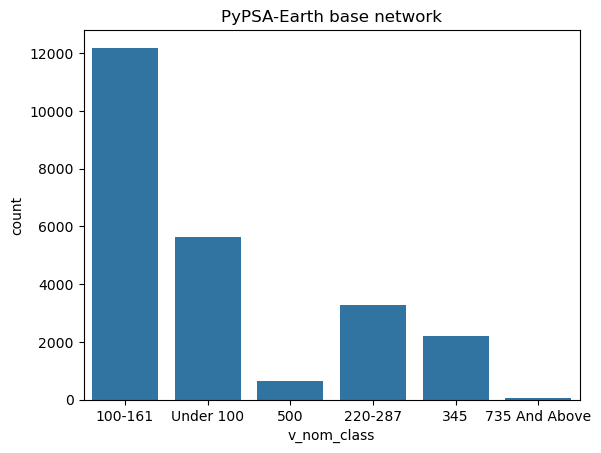

In [76]:
sbn.countplot(data=base_network_pypsa_earth.lines, x=base_network_pypsa_earth.lines["v_nom_class"]).set(title='PyPSA-Earth base network')

[Text(0.5, 1.0, 'EIA network topology')]

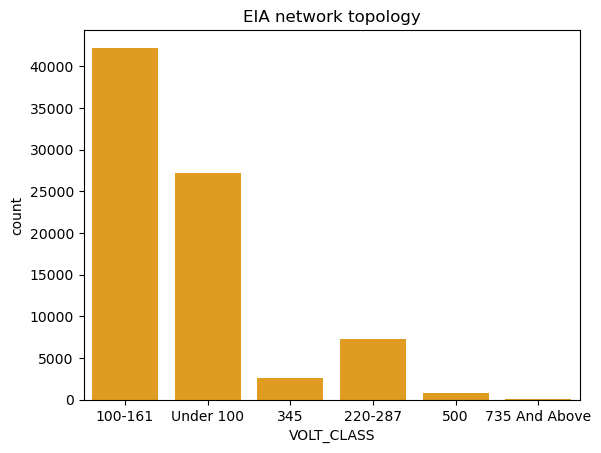

In [78]:
sbn.countplot(data=eia_base_network, x=eia_base_network["VOLT_CLASS"], color="orange").set(title='EIA network topology')

#### Maps